In [1]:
import matplotlib.pyplot as plt 
%load_ext autoreload
%autoreload 2

In [2]:
from velotest.hypothesis_testing import run_hypothesis_test_on
from velotest.plotting import arrow_plot, marker_plot
import scvelo
import matplotlib.pyplot as plt

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/Users/sebastian/tuebingen/openTSNE/venv/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


/Users/sebastian/tuebingen/openTSNE/venv/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
vkey='velocity', scale=10, self_transitions=True, use_negative_cosines=True
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/sebastian/tuebingen/openTSNE/venv/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/sebastian/tuebingen/openTSNE/venv/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/sebastian/tuebingen/openTSNE/venv/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/sebastian/tuebingen/openTSNE/venv/li

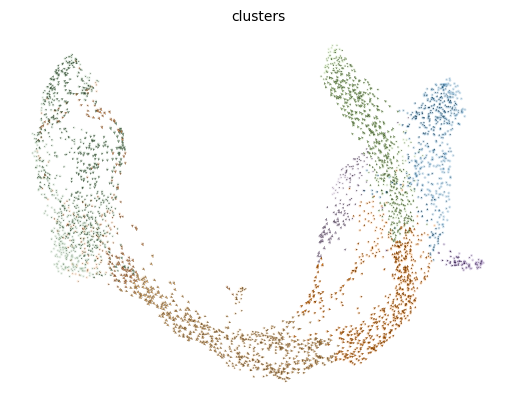

In [3]:
adata = scvelo.datasets.pancreas()
scvelo.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scvelo.pp.moments(adata, n_pcs=30, n_neighbors=30)

# Compute velocity
scvelo.tl.velocity(adata)

# Compute 2D embedding of velocity vectors
scvelo.tl.velocity_graph(adata)
scvelo.pl.velocity_embedding(adata)

In [4]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(adata, number_neighbors_to_sample_from=300, number_neighborhoods=500, null_distribution="velocities", cosine_empty_neighborhood=None, correction="bonferroni", restrict_to_velocity_genes=True)

Dropping all the genes which are not velocity genes. 1038 genes left.


100%|██████████| 692/692 [02:11<00:00,  5.27it/s]


<Axes: >

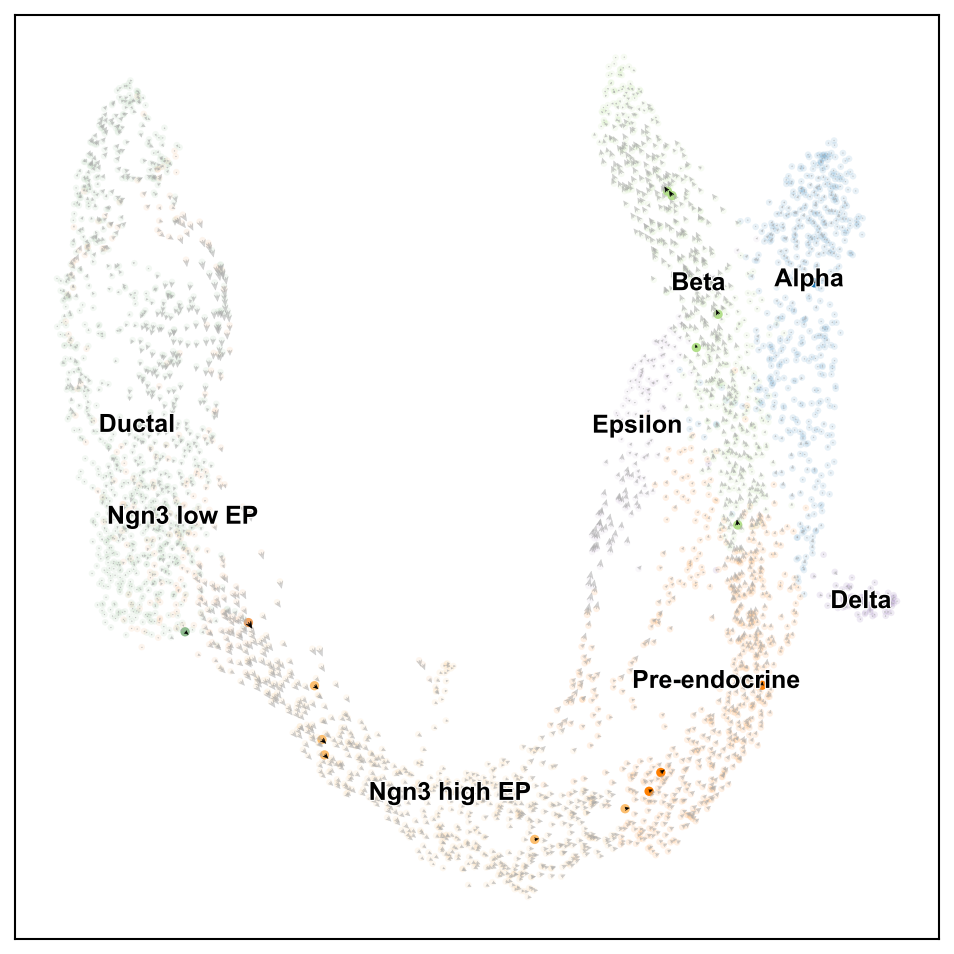

In [5]:
# Plotting
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_umap'], adata.obsm['X_umap']+adata.obsm['velocity_umap'], uncorrected_p_values, h0_rejected, labels=labels, label_colormap=color_dict)

Text(0.5, 1.0, 'Without correction')

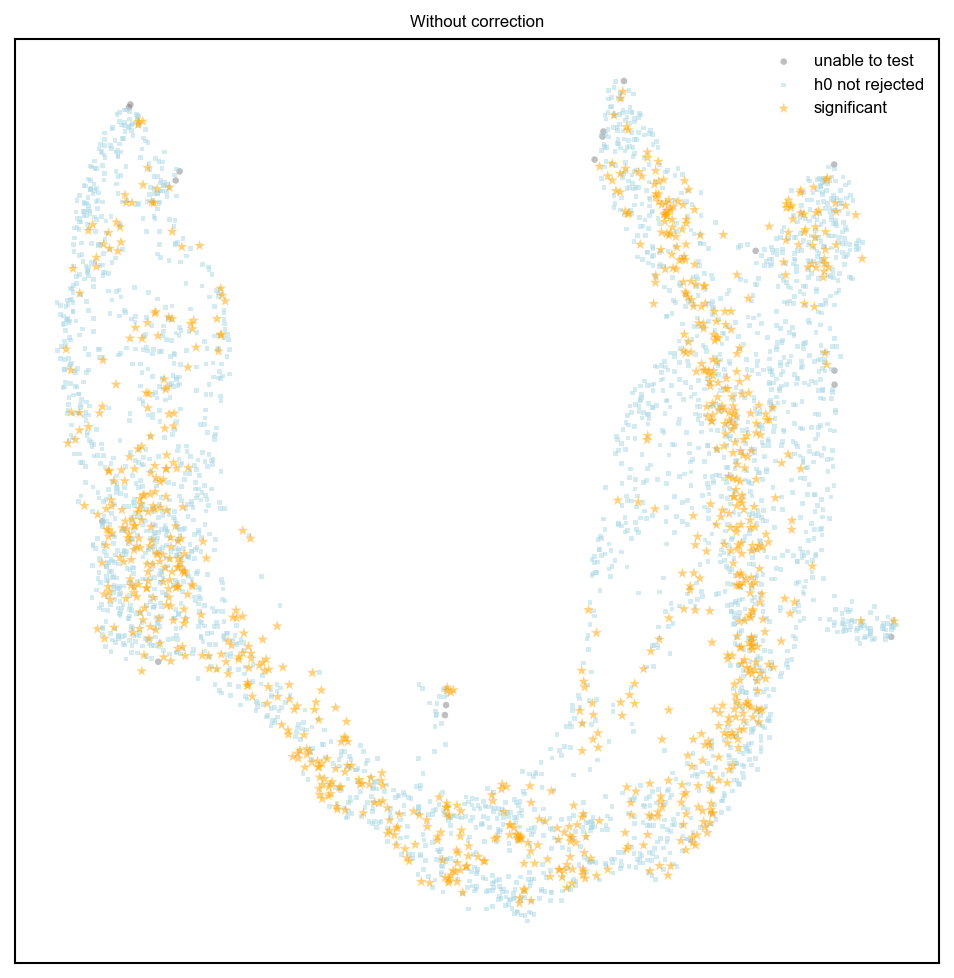

In [6]:
rejection_wo_correction = uncorrected_p_values < 0.05
rejection_wo_correction[uncorrected_p_values==2] = False

marker_plot(adata.obsm['X_umap'], uncorrected_p_values, rejection_wo_correction, multiplier_marker_size=0.5)
plt.title("Without correction")

(0.0, 348.0)

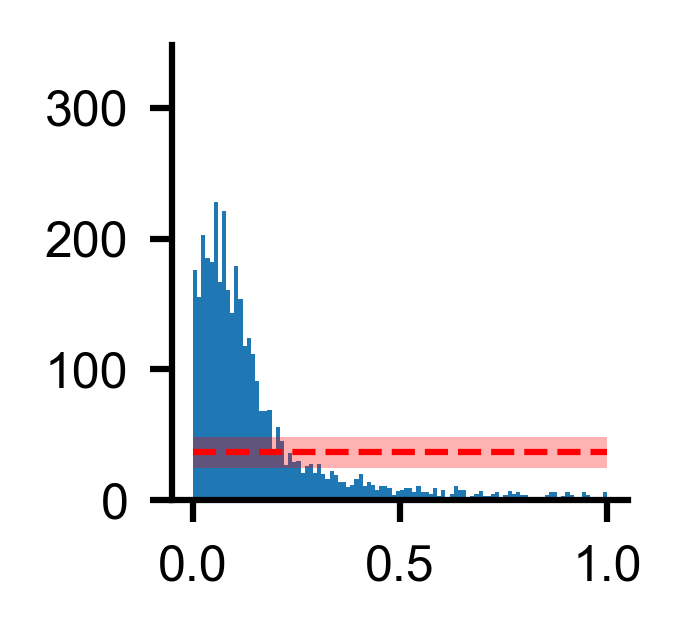

In [7]:
import numpy as np
import matplotlib as mpl
mpl.rc_file("../matplotlibrc")

cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(dpi=450, constrained_layout=True, figsize=(3.5 * cm, 3.5 * cm))
ax.set(box_aspect=1)

samples = uncorrected_p_values[uncorrected_p_values<2]
bins = 100
plt.hist(samples, bins=bins, label="p-values")
N = len(samples)
p = 1/bins
ax.hlines(N*p, color="red", linestyle="--", label="Exp. value under Uniformity", xmin=0, xmax=1)
plt.fill_between(np.arange(0, 2), N*p-1.96* np.sqrt(N*p*(1-p)), N*p+1.96* np.sqrt(N*p*(1-p)), color="red", alpha=0.3, edgecolor=None)

assert plt.ylim()[0]<=348
plt.ylim(top=348)
#plt.xlabel("p-value")
#plt.ylabel("Count")

plt.savefig("fig/04_demo-uniformity_histogram-same_y.pdf", dpi=450, transparent=True)